In [1]:
# required to import local package

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
from torch_geometric.datasets import Planetoid

# download dataset using ogb pytorch geometric loader.
dataset = Planetoid("dataset", "PubMed")

data = dataset[0] # pyg graph object

print(data)

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


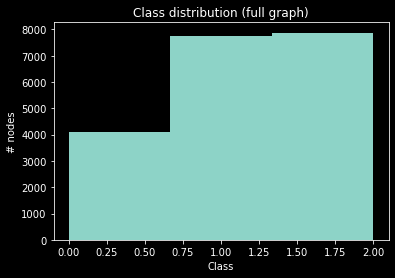

In [3]:
import matplotlib.pyplot as plt

plt.title("Class distribution (full graph)")
plt.hist(data.y.reshape(-1).detach().numpy(), dataset.num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

graph is strongly connected component: True
graph is weakly connected component: True
graph has # weakly connected components: 1
graph has # isolated nodes: 0


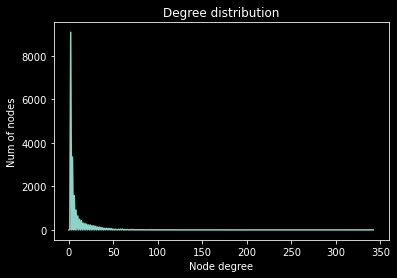

In [4]:
from lib import util

util.describe_graph(data)

## Split data set

In [5]:
from lib.data import split_dataset

train_data, calibration_indices, test_indices = split_dataset(data, 0.2, 0.2)

print("Train set: {}".format(train_data))
print("Calibration set size: {}".format(len(calibration_indices)))
print("Test set size: {}".format(len(test_indices)))

Train set: Data(x=[12620, 500], edge_index=[2, 35694], y=[12620])
Calibration set size: 3154
Test set size: 3943


## Inspect Train set

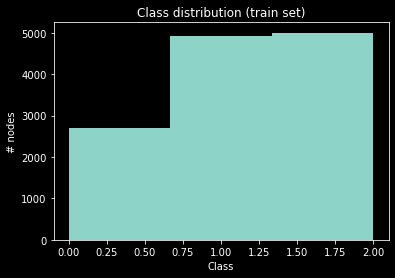

In [6]:
plt.title("Class distribution (train set)")
plt.hist(train_data.y.reshape(-1).detach().numpy(), dataset.num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

graph is strongly connected component: False
graph is weakly connected component: False
graph has # weakly connected components: 2633
graph has # isolated nodes: 2539


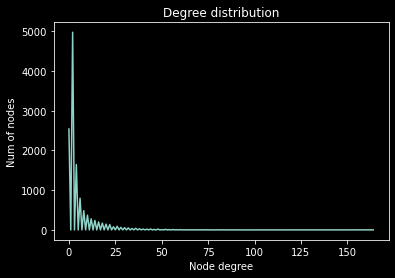

In [7]:
util.describe_graph(train_data)

## Inspect calibration data

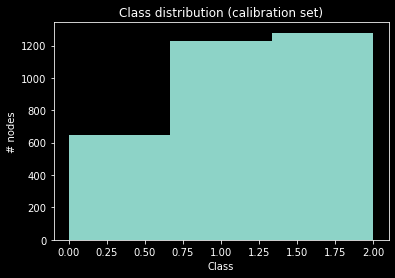

In [8]:
plt.title("Class distribution (calibration set)")
plt.hist(data.y[calibration_indices].reshape(-1).detach().numpy(), dataset.num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

## Inspect test data

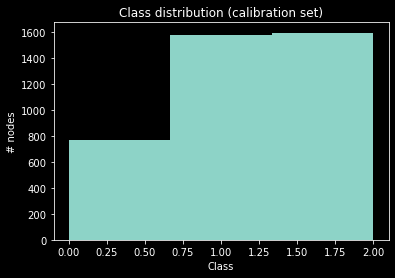

In [9]:
plt.title("Class distribution (calibration set)")
plt.hist(data.y[test_indices].reshape(-1).detach().numpy(), dataset.num_classes)
plt.xlabel("Class")
plt.ylabel("# nodes")
plt.show()

# GraphSAGE model

In [10]:
from lib.graphsage import GraphSAGE
from lib.evaluation import get_multiclass_classification_performance

args = {
    "num_layers": 2,
    "hidden_dim": 256,
    "lr": 0.01, # learning rate
    "epochs": 50,
    "batch_size": 1024,
    "num_neighbors": [10,3],
}

model = GraphSAGE(data.num_features, args["hidden_dim"], dataset.num_classes, args["num_layers"], args["num_neighbors"])


# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

loss_fn = torch.nn.NLLLoss()

for epoch in range(1, 1 + args["epochs"]):
    print(f"Epoch: {epoch:02d}")
    loss = model.train_model(train_data, optimizer, loss_fn, args["batch_size"])
    
# evaluate
model.eval()

y_hat = model.predict(data)
y_hat = y_hat[test_indices]
y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)

y_true = data.y[test_indices].reshape(-1)

acc, balanced_acc = get_multiclass_classification_performance(y_hat, y_true)

print(f"Model found \n"
        f"Test acc: {100 * acc:.2f}%, "
        f"Test balanced acc: {100 * balanced_acc:.2f}%")

Epoch: 01
Epoch: 02
Epoch: 03
Epoch: 04
Epoch: 05
Epoch: 06
Epoch: 07
Epoch: 08
Epoch: 09
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Model found 
Test acc: 88.38%, Test balanced acc: 87.38%


### Performance per node (in-)degreee

/usr/local/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


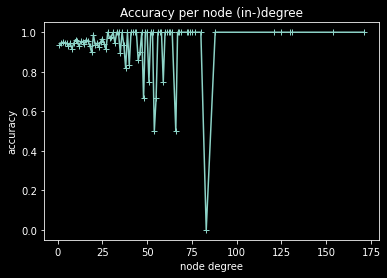

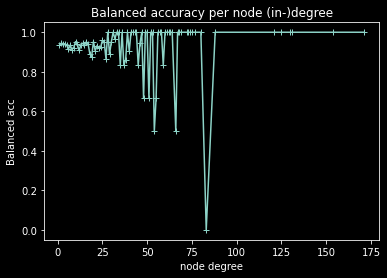

In [11]:
from lib.util import plot

y_hat = model.predict(data)
y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)
y_true = data.y.reshape(-1)

node_idx, node_degree = torch.unique(data.edge_index[1], return_counts=True)
nd = torch.zeros(data.x.shape[0]).long()
nd[node_idx] = node_degree

degrees = torch.unique(node_degree)

degrees_with_samples = []
accs = []
balanced_accs = []
for d in degrees:
  degree_mask = nd == d
  if y_hat[degree_mask].shape[0] > 0:
    acc, balanced_acc = get_multiclass_classification_performance(y_hat[degree_mask], y_true[degree_mask])

    degrees_with_samples.append(d)
    accs.append(acc)
    balanced_accs.append(balanced_acc)

plot("Accuracy per node (in-)degree", degrees_with_samples, accs, "node degree", "accuracy")
plot("Balanced accuracy per node (in-)degree", degrees_with_samples, balanced_accs, "node degree", "Balanced acc")

# Conformal prediction (standard)

In [12]:
from lib.conformal_predictor import ConformalClassifier, get_nonconformity_measure_for_classification

NONCONFORMITY_MEASURE = "v2"

cal_y_hat = model.predict(data)
cal_y_hat = cal_y_hat[calibration_indices]
y_true = data.y[calibration_indices]
cal_y_hat = cal_y_hat
y_true = y_true
y_true = y_true.reshape(-1).detach()

cal_alphas = []
for y_probas, yt in zip(cal_y_hat,y_true):
  y = yt.item()
  alphas = get_nonconformity_measure_for_classification(y_probas, version=NONCONFORMITY_MEASURE)
  cal_alphas.append(alphas[y])

cal_alphas = torch.tensor(cal_alphas)
cal_y = y_true

cp = ConformalClassifier(cal_alphas, cal_y)

## coverage and efficiency

In [13]:
from lib.evaluation import get_coverage_and_efficiency

CONFIDENCE_LEVEL = 0.95

def get_confidence_intervals(cp, y_hat, confidence_level=0.95, mondrian_category=None):
  confidence_intervals = []
  for yi in y_hat:
    alphas = get_nonconformity_measure_for_classification(yi, version=NONCONFORMITY_MEASURE)
    ci = cp.predict(alphas, confidence_level, mondrian_category)
    confidence_intervals.append(ci)
  
  return confidence_intervals

y_hat = model.predict(data)
y_true = data.y
# get test indices
y_hat = y_hat[test_indices]
y_true = y_true[test_indices]

### Overall

In [14]:
from lib.util import print_percentage

confidence_intervals = get_confidence_intervals(cp, y_hat, CONFIDENCE_LEVEL)

coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true)

def print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred):
  print_percentage("Coverage", coverage)
  print("Avg prediction set size: {:.2f}".format(avg_prediction_set_size))
  print_percentage("Singleton predictions", frac_singleton_pred)
  print_percentage("Empty predictions", frac_empty_pred)

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred)

Confidence level: 95.00%
Coverage: 89.09%
Avg prediction set size: 1.02
Singleton predictions: 98.45%
Empty predictions: 0.00%


### Per class

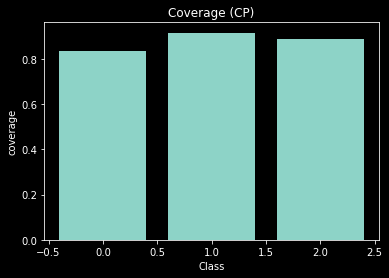

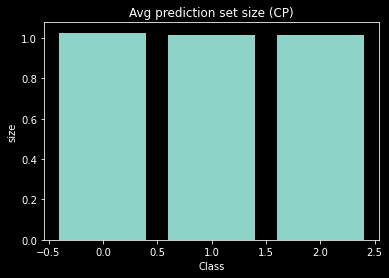

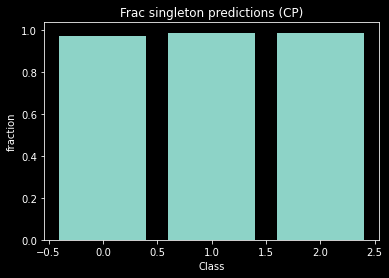

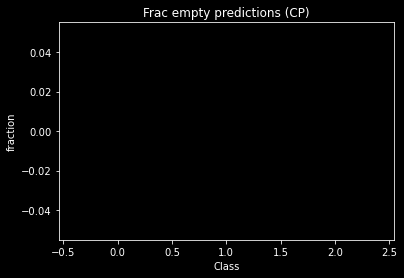

In [15]:
coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
for c in range(dataset.num_classes):
  class_mask = y_true == c

  confidence_intervals = get_confidence_intervals(cp, y_hat[class_mask], CONFIDENCE_LEVEL)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[class_mask])

  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

def plot_bar(title, x, y, x_label, y_label, save_file=False):
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.bar(x, y)
  if save_file:
    plt.savefig(title + ".png")
  plt.show()

save_plot = False
x_label = "Class"
classes = range(dataset.num_classes)
plot_bar("Coverage (CP)", classes, coverages, x_label, "coverage", save_plot)
plot_bar("Avg prediction set size (CP)", classes, avg_prediction_set_sizes, x_label, "size", save_plot)
plot_bar("Frac singleton predictions (CP)", classes, frac_singleton_preds, x_label, "fraction", save_plot)
plot_bar("Frac empty predictions (CP)", classes, frac_empty_preds, x_label, "fraction", save_plot)

### per node (in-)degree

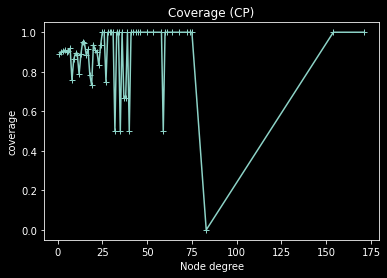

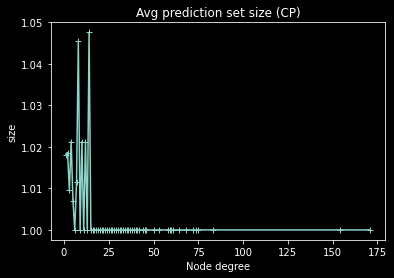

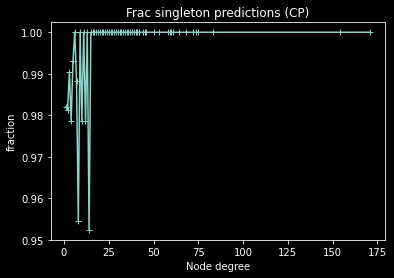

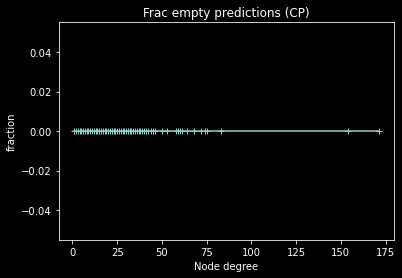

In [16]:
node_idx, node_degree = torch.unique(data.edge_index[1], return_counts=True)
nd = torch.zeros(data.x.shape[0]).long()
nd[node_idx] = node_degree
# only keep test indices
nd = nd[test_indices]

degrees = torch.unique(nd)

degrees_with_samples = []
coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
for d in degrees:
  degree_mask = nd == d
  if y_true[degree_mask].shape[0] == 0:
    continue

  confidence_intervals = get_confidence_intervals(cp, y_hat[degree_mask], CONFIDENCE_LEVEL)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_mask])

  degrees_with_samples.append(d)
  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

save_plot = False
x_label = "Node degree"
plot("Coverage (CP)", degrees_with_samples, coverages, x_label, "coverage", save_plot)
plot("Avg prediction set size (CP)", degrees_with_samples, avg_prediction_set_sizes, x_label, "size", save_plot)
plot("Frac singleton predictions (CP)", degrees_with_samples, frac_singleton_preds, x_label, "fraction", save_plot)
plot("Frac empty predictions (CP)", degrees_with_samples, frac_empty_preds, x_label, "fraction", save_plot)

# Mondrian Conformal Prediction (MCP) (class-based)

In [17]:
mcp_class = ConformalClassifier(cal_alphas, cal_y, True)

## Performance
### Overall

In [18]:
confidence_intervals = get_confidence_intervals(mcp_class, y_hat, CONFIDENCE_LEVEL)

coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true)

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred)


Confidence level: 95.00%
Coverage: 89.32%
Avg prediction set size: 1.02
Singleton predictions: 96.86%
Empty predictions: 0.41%


### Per class

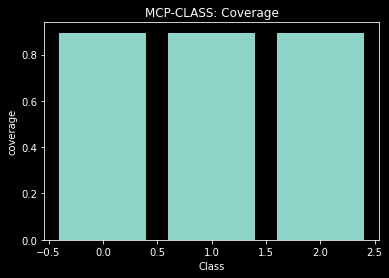

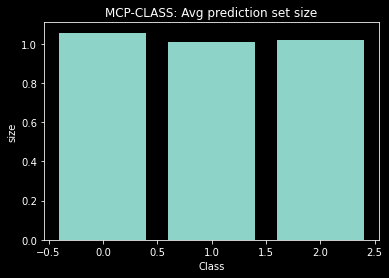

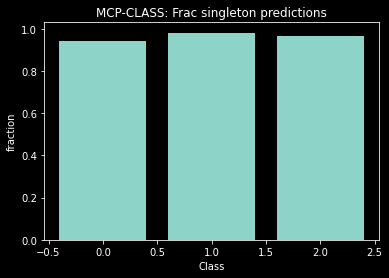

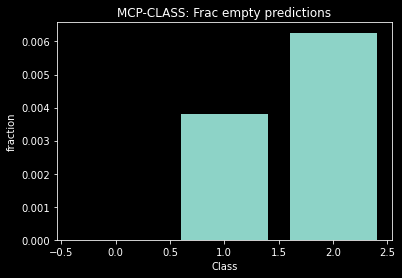

In [19]:
coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
for c in range(dataset.num_classes):
  class_mask = y_true == c

  confidence_intervals = get_confidence_intervals(mcp_class, y_hat[class_mask], CONFIDENCE_LEVEL)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[class_mask])

  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

save_plot = False
x_label = "Class"
classes = range(dataset.num_classes)
plot_bar("MCP-CLASS: Coverage", classes, coverages, x_label, "coverage", save_plot)
plot_bar("MCP-CLASS: Avg prediction set size", classes, avg_prediction_set_sizes, x_label, "size", save_plot)
plot_bar("MCP-CLASS: Frac singleton predictions", classes, frac_singleton_preds, x_label, "fraction", save_plot)
plot_bar("MCP-CLASS: Frac empty predictions", classes, frac_empty_preds, x_label, "fraction", save_plot)

### Per node (in-)degree

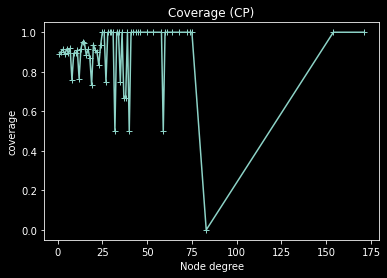

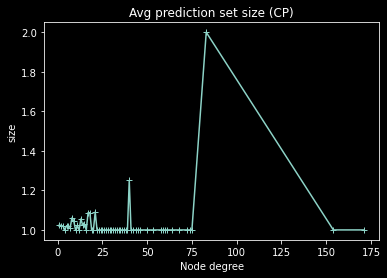

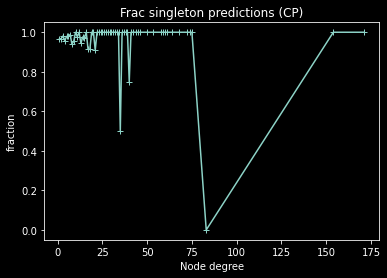

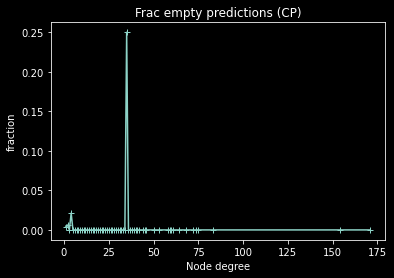

In [20]:
degrees_with_samples = []
coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
for d in degrees:
  degree_mask = torch.logical_and(nd == d, y_true != -1)
  if y_true[degree_mask].shape[0] == 0:
    continue

  confidence_intervals = get_confidence_intervals(mcp_class, y_hat[degree_mask], CONFIDENCE_LEVEL)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_mask])

  degrees_with_samples.append(d)
  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

save_plot = False
x_label = "Node degree"
plot("Coverage (CP)", degrees_with_samples, coverages, x_label, "coverage", save_plot)
plot("Avg prediction set size (CP)", degrees_with_samples, avg_prediction_set_sizes, x_label, "size", save_plot)
plot("Frac singleton predictions (CP)", degrees_with_samples, frac_singleton_preds, x_label, "fraction", save_plot)
plot("Frac empty predictions (CP)", degrees_with_samples, frac_empty_preds, x_label, "fraction", save_plot)

# MCP (node (in-)degree based)

In [25]:
BINS = torch.tensor([0,1,2,3,4,5,6,7,8,9,10,20,30]) # boundaries[i-1] < input[x] <= boundaries[i]

# get node degrees
c_node_ids, c_node_degrees = torch.unique(data.edge_index[1], return_counts=True)
cal_node_degrees = torch.zeros(data.x.shape[0]).long()
cal_node_degrees[c_node_ids] = c_node_degrees

cal_node_degrees = cal_node_degrees[calibration_indices] # only use calibration nodes


c_node_degrees_bins = torch.bucketize(cal_node_degrees, BINS)

calibration_taxonomy = c_node_degrees_bins

mcp_node_degree = ConformalClassifier(cal_alphas, cal_y, True, calibration_taxonomy)

## Performance

### Overall

Confidence level: 95.00%
Coverage: 89.64%
Avg prediction set size: 1.03
Singleton predictions: 96.98%
Empty predictions: 0.14%


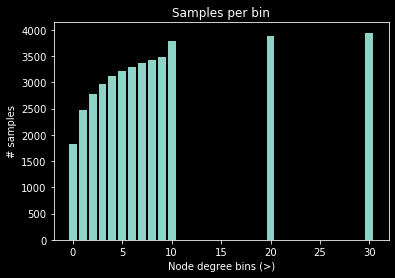

In [26]:
nd_bins = torch.bucketize(nd, BINS)

degrees = torch.unique(nd_bins)

coverages = []
avg_prediction_set_sizes = []
frac_singleton_preds = []
frac_empty_preds = []
samples_per_bin = []

for d in degrees:
  degree_mask = nd_bins <= d
  
  confidence_intervals = get_confidence_intervals(mcp_node_degree, y_hat[degree_mask], CONFIDENCE_LEVEL, d)
  
  coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_mask])

  samples_per_bin.append(y_true[degree_mask].shape[0])
  coverages.append(coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  frac_singleton_preds.append(frac_singleton_pred)
  frac_empty_preds.append(frac_empty_pred)

dataset_size = torch.sum(torch.tensor(samples_per_bin))
avg_coverage = torch.sum(torch.tensor(coverages) * torch.tensor(samples_per_bin) / dataset_size)
avg_prediction_set_size = torch.sum(torch.tensor(avg_prediction_set_sizes) * torch.tensor(samples_per_bin) / dataset_size) 
avg_frac_singleton_pred = torch.sum(torch.tensor(frac_singleton_preds) * torch.tensor(samples_per_bin) / dataset_size) 
avg_frac_empty_pred = torch.sum(torch.tensor(frac_empty_preds) * torch.tensor(samples_per_bin) / dataset_size) 

print_percentage("Confidence level", CONFIDENCE_LEVEL)
print_coverage_and_efficiency(avg_coverage, avg_prediction_set_size, avg_frac_singleton_pred, avg_frac_empty_pred)

plot_bar("Samples per bin", BINS, samples_per_bin, "Node degree bins (>)", "# samples", False)

### Performance per node degree bucket

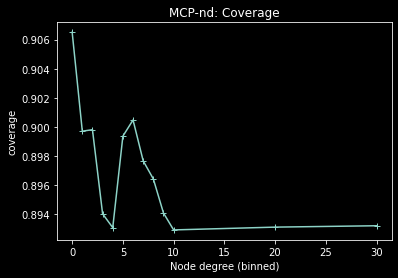

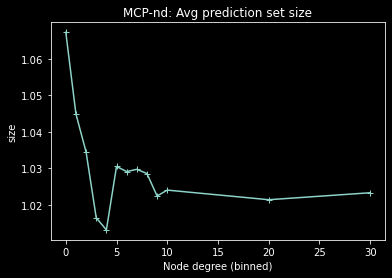

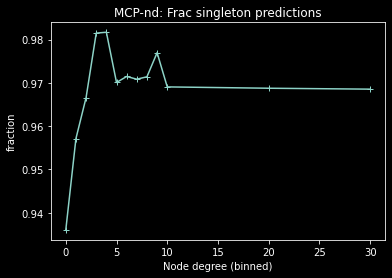

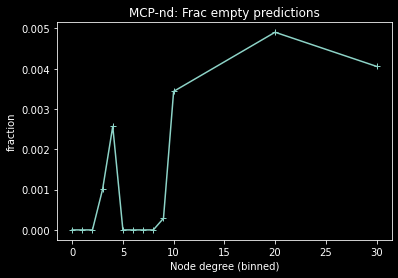

In [27]:
save_plot = False
x_label = "Node degree (binned)"
plot("MCP-nd: Coverage", BINS, coverages, x_label, "coverage", save_plot)
plot("MCP-nd: Avg prediction set size", BINS, avg_prediction_set_sizes, x_label, "size", save_plot)
plot("MCP-nd: Frac singleton predictions", BINS, frac_singleton_preds, x_label, "fraction", save_plot)
plot("MCP-nd: Frac empty predictions", BINS, frac_empty_preds, x_label, "fraction", save_plot)

### Performance per class

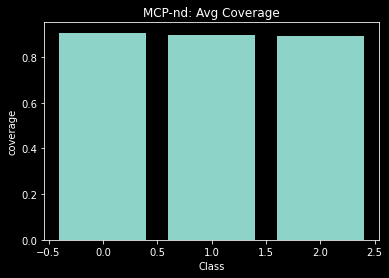

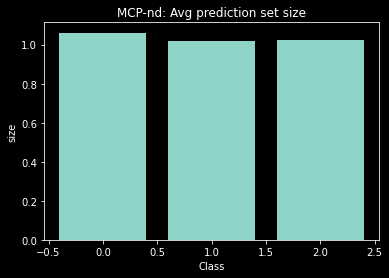

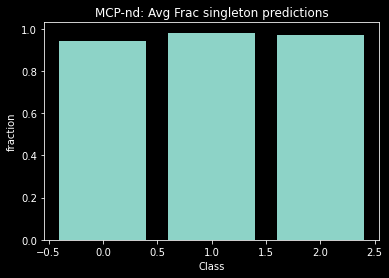

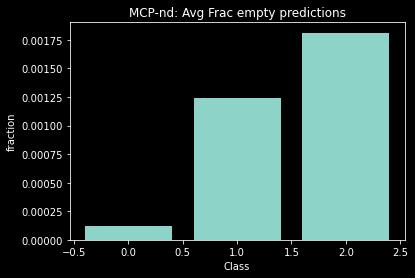

In [29]:
avg_coverages = []
avg_prediction_set_sizes = []
avg_frac_singleton_preds = []
avg_frac_empty_preds = []
for c in range(dataset.num_classes):
  coverages = []
  prediction_set_sizes = []
  frac_singleton_preds = []
  frac_empty_preds = []
  for d in degrees:
    degree_class_mask = torch.logical_and(nd_bins <= d, y_true == c)

    confidence_intervals = get_confidence_intervals(mcp_node_degree, y_hat[degree_class_mask], CONFIDENCE_LEVEL, d)
    
    coverage, avg_prediction_set_size, frac_singleton_pred, frac_empty_pred = get_coverage_and_efficiency(confidence_intervals, y_true[degree_class_mask])

    coverages.append(coverage)
    prediction_set_sizes.append(avg_prediction_set_size)
    frac_singleton_preds.append(frac_singleton_pred)
    frac_empty_preds.append(frac_empty_pred)
  
  avg_coverage = torch.tensor(coverages).mean()
  avg_prediction_set_size = torch.tensor(prediction_set_sizes).mean()
  avg_frac_singleton_pred = torch.tensor(frac_singleton_preds).mean()
  avg_frac_empty_pred = torch.tensor(frac_empty_preds).mean()

  avg_coverages.append(avg_coverage)
  avg_prediction_set_sizes.append(avg_prediction_set_size)
  avg_frac_singleton_preds.append(avg_frac_singleton_pred)
  avg_frac_empty_preds.append(avg_frac_empty_pred)

save_plot = False
x_label = "Class"
classes = range(dataset.num_classes)
plot_bar("MCP-nd: Avg Coverage", classes, avg_coverages, x_label, "coverage", save_plot)
plot_bar("MCP-nd: Avg prediction set size", classes, avg_prediction_set_sizes, x_label, "size", save_plot)
plot_bar("MCP-nd: Avg Frac singleton predictions", classes, avg_frac_singleton_preds, x_label, "fraction", save_plot)
plot_bar("MCP-nd: Avg Frac empty predictions", classes, avg_frac_empty_preds, x_label, "fraction", save_plot)